Build a mesh for the Next Step TF cross-section
==========

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh, gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
def create_arc(phi_start,phi_end,R0,Z0,radius,npts):
    theta = np.linspace(phi_start,phi_end,npts)
    r = np.zeros((npts,2))
    r[:,0] = R0 + radius*np.cos(theta)
    r[:,1] = Z0 + radius*np.sin(theta)
    return r

In [4]:
tf_dx = 0.05
#
inner_R0 = 0.230
leg_width = 0.270
bore = 1.050
height = 2.340
inner_radius = 0.100

## Build geometry

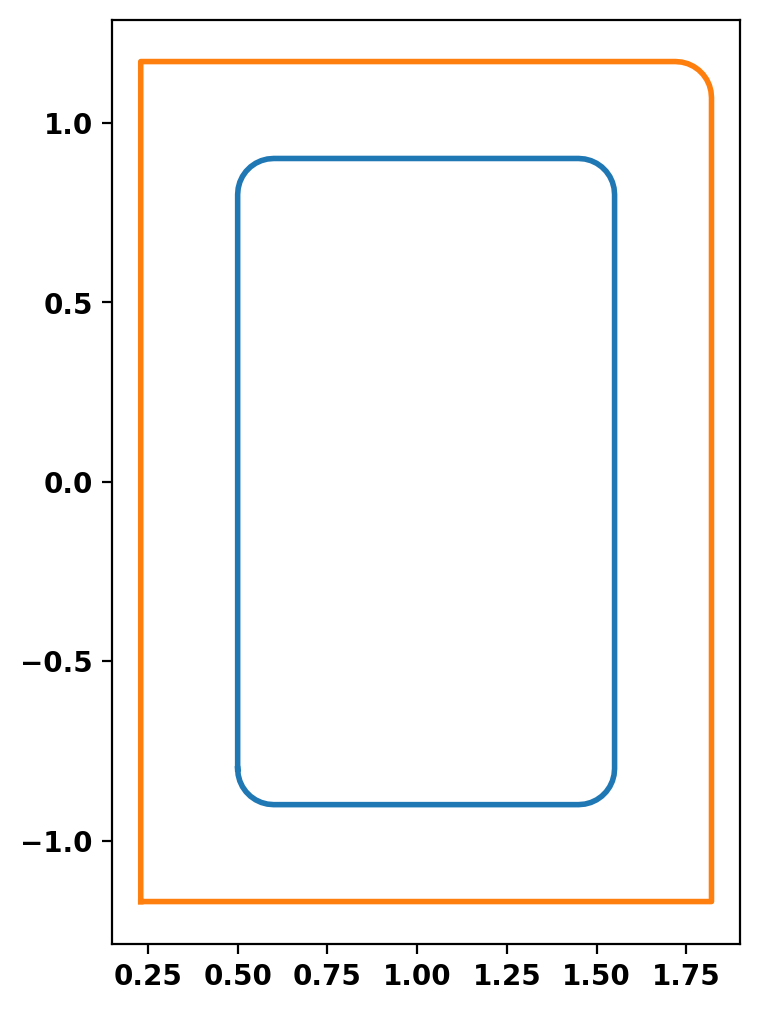

In [5]:
fig, ax = plt.subplots(1,1)
inner_curve = np.vstack((
    create_arc(-np.pi,-np.pi/2.0,inner_R0+leg_width+inner_radius,-(height/2.0-leg_width-inner_radius),inner_radius,10),
    create_arc(-np.pi/2.0,0.0,inner_R0+leg_width+bore-inner_radius,-(height/2.0-leg_width-inner_radius),inner_radius,10),
    create_arc(0.0,np.pi/2.0,inner_R0+leg_width+bore-inner_radius,(height/2.0-leg_width-inner_radius),inner_radius,10),
    create_arc(np.pi/2.0,np.pi,inner_R0+leg_width+inner_radius,(height/2.0-leg_width-inner_radius),inner_radius,10),
    create_arc(-np.pi,-np.pi/2.0,inner_R0+leg_width+inner_radius,-(height/2.0-leg_width-inner_radius),inner_radius,2)[0,:]
))
ax.plot(inner_curve[:,0],inner_curve[:,1])
#
outer_curve = np.vstack((
    [[inner_R0,-height/2.0],],
    [[inner_R0+bore+2.0*leg_width,-height/2.0],],
    create_arc(0.0,np.pi/2.0,inner_R0+2*leg_width+bore-inner_radius,(height/2.0-inner_radius),inner_radius,10),
    [[inner_R0,height/2.0],],
    [[inner_R0,-height/2.0],]
))
ax.plot(outer_curve[:,0],outer_curve[:,1])

ax.set_aspect('equal','box')

## Generate mesh

In [6]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',tf_dx,'plasma')
gs_mesh.define_region('vac',tf_dx,'vacuum')

In [7]:
gs_mesh.add_annulus(inner_curve,'vac',outer_curve,'plasma')

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh(require_boundary=False)

Assembling regions:
  # of unique points    = 264
  # of unique segments  = 4
Generating mesh:
  # of points  = 2359
  # of cells   = 4562
  # of regions = 2


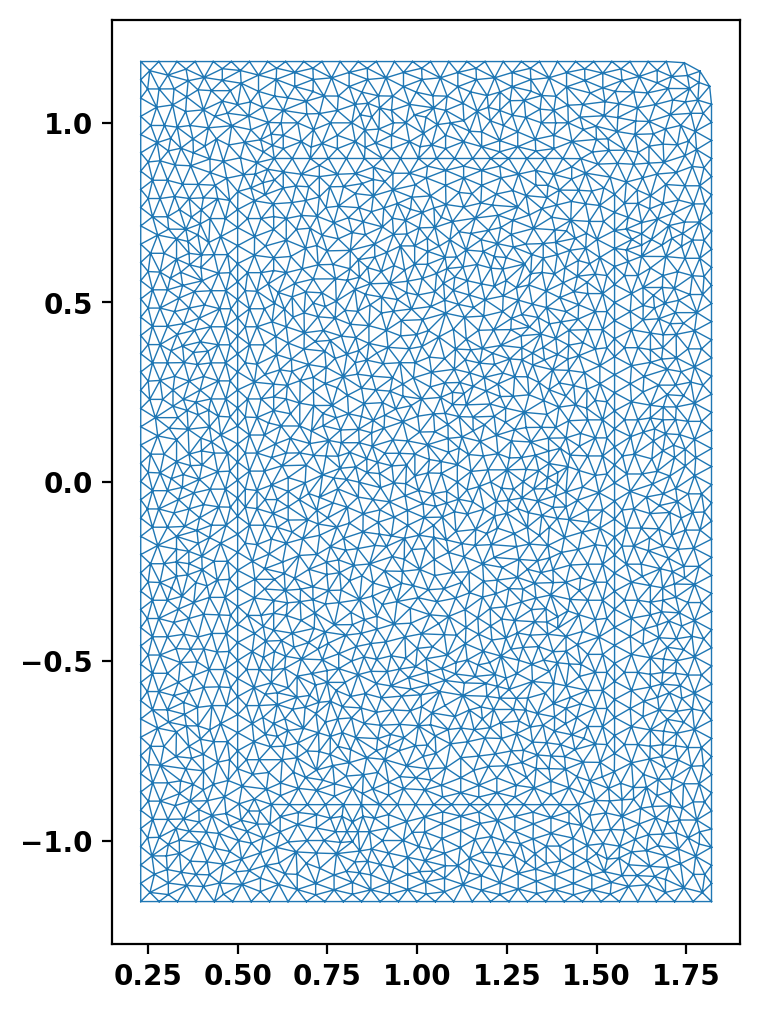

In [9]:
fig, ax = plt.subplots(1,1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,lw=0.5)
ax.set_aspect('equal','box')

## Remove interior of mesh

In [10]:
pt_flag = np.zeros((mesh_pts.shape[0],),dtype=np.int32)
pt_flag[mesh_lc[mesh_reg==1,:]] = 1
reindex = np.cumsum(pt_flag)
new_pts = mesh_pts[pt_flag!=0,:]
new_lc = reindex[mesh_lc[mesh_reg==1,:]]-1

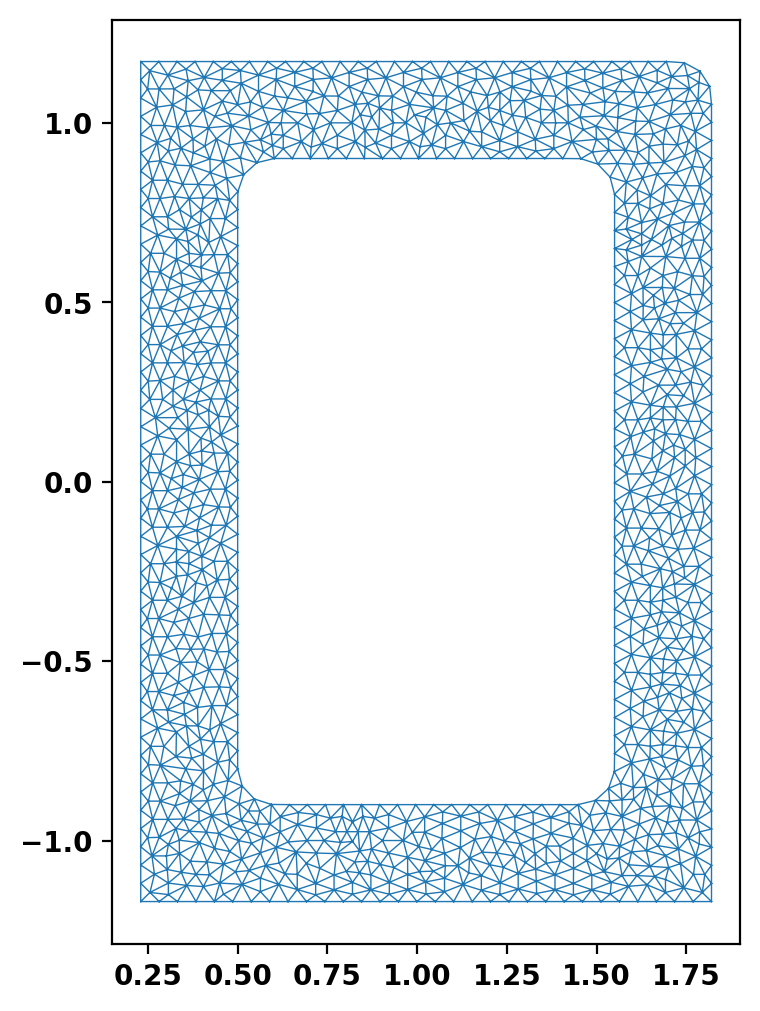

In [11]:
fig, ax = plt.subplots(1,1)
ax.triplot(new_pts[:,0],new_pts[:,1],new_lc,lw=0.5)
ax.set_aspect('equal','box')

## Save mesh for use in other notebook

In [12]:
with open('TF_mesh.json', 'w+') as fid:
    fid.write(json.dumps({
        "pts": new_pts.tolist(),
        "lc": new_lc.tolist()
    }))